<h1><center>Sales Analysis<center><h1>

In [35]:
# Load libraries for analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [32]:
plt.rcParams['figure.figsize'] = [10,8]
plt.rc('axes', titlesize= 20, labelsize =15)

In [36]:
warnings.filterwarnings('ignore')

In [ ]:
# Load data and display the first five rows.
sales = pd.read_csv('sales_data.csv')
sales.head()

,Product_ID,Sale_Date,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
0,1052,2023-02-03,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
1,1093,2023-04-21,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2,1015,2023-09-21,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
3,1072,2023-08-24,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
4,1061,2023-03-24,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie


In [13]:
# Display shape of the data frame.
print("The dimension of the data frame is:", sales.shape)

The dimension of the data frame is: (1000, 14)


In [ ]:
# Display data types.
print("The data types in the data frame are:\n", sales.dtypes)

The data types in the data frame are:
 Product_ID                       int64
Sale_Date               datetime64[ns]
Sales_Rep                       object
Region                          object
Sales_Amount                   float64
Quantity_Sold                    int64
Product_Category                object
Unit_Cost                      float64
Unit_Price                     float64
Customer_Type                   object
Discount                       float64
Payment_Method                  object
Sales_Channel                   object
Region_and_Sales_Rep            object
dtype: object


In [20]:
# Convert Sale Date column from object to time stamp.
sales['Sale_Date'] = pd.to_datetime(sales['Sale_Date']) 
sales['Sale_Date'].dtype

dtype('<M8[ns]')

In [ ]:
# Convert sales date from a column to an index and display new data frame.
sales_t = sales.set_index('Sale_Date')
sales_t.head()

,Product_ID,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
Sale_Date,,,,,,,,,,,,,
2023-02-03,1052,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
2023-04-21,1093,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2023-09-21,1015,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
2023-08-24,1072,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
2023-03-24,1061,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie


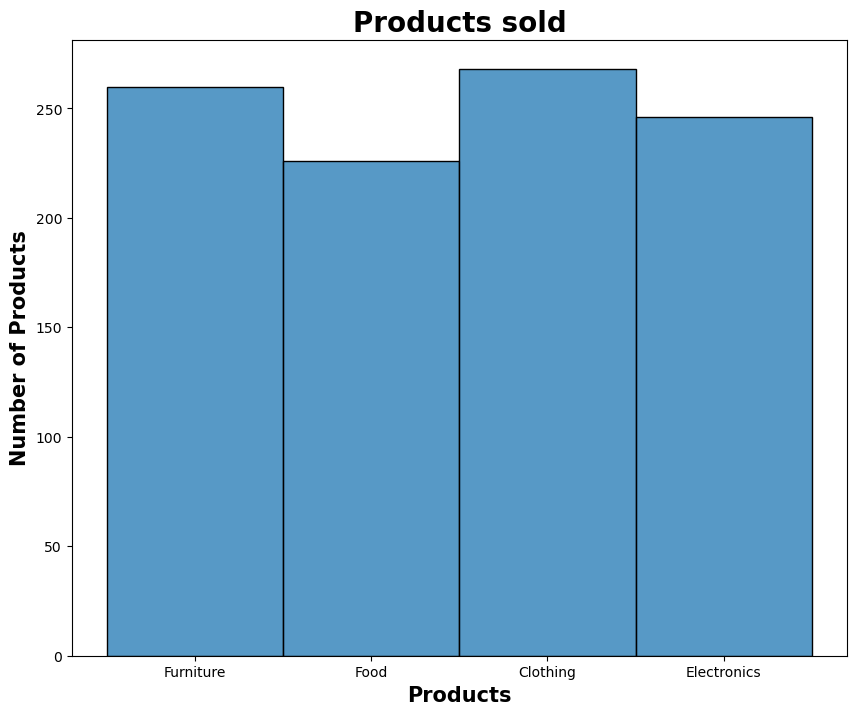

In [34]:
sns.histplot(data= sales_t, x = 'Product_Category')
plt.title('Products sold', weight ='bold')
plt.xlabel('Products', weight = 'bold')
plt.ylabel('Number of Products', weight = 'bold')

plt.show()